In [8]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [82]:
from pathlib import Path
import pandas as pd

def get_paths_labels(path, allowed_extension="jpg"):
    images_dir = Path(path)
    
    filepaths = pd.Series(images_dir.glob(fr'**/*.{allowed_extension}')).astype(str)
    filepaths.name = "path"
    
    # Extract labels using apply method
    labels = filepaths.apply(lambda x: Path(x).parts[-2])
    labels.name = "label"

    # Concatenate filepaths and labels
    df = pd.concat([filepaths, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    return df


In [75]:
# Read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [76]:
# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()
    

In [6]:
#Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [73]:
# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])
    
    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()

In [102]:
# Read datasets

# Create dataframe of {paths, labels}
train_df = get_paths_labels('D:/Jwalitha/Projects/AIML/Machine learning projects/SIGN LANGUAGE/asl_alphabet_train/asl_alphabet_train')
print(train_df.head())


                                                path  label
0  D:\Jwalitha\Projects\AIML\Machine learning pro...      S
1  D:\Jwalitha\Projects\AIML\Machine learning pro...      O
2  D:\Jwalitha\Projects\AIML\Machine learning pro...      R
3  D:\Jwalitha\Projects\AIML\Machine learning pro...      Y
4  D:\Jwalitha\Projects\AIML\Machine learning pro...  space


In [103]:
# Classes counts
print("Classes counts")
counts = train_df.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")

Classes counts
label
A          3000
B          3000
C          3000
D          3000
E          3000
F          3000
G          3000
H          3000
I          3000
J          3000
K          3000
L          3000
M          3000
N          3000
O          3000
P          3000
Q          3000
R          3000
S          3000
T          3000
U          3000
V          3000
W          3000
X          3000
Y          3000
Z          3000
del        3000
nothing    3000
space      3000
Name: count, dtype: int64


Dataset size = 87000 samples


In [106]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)

Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


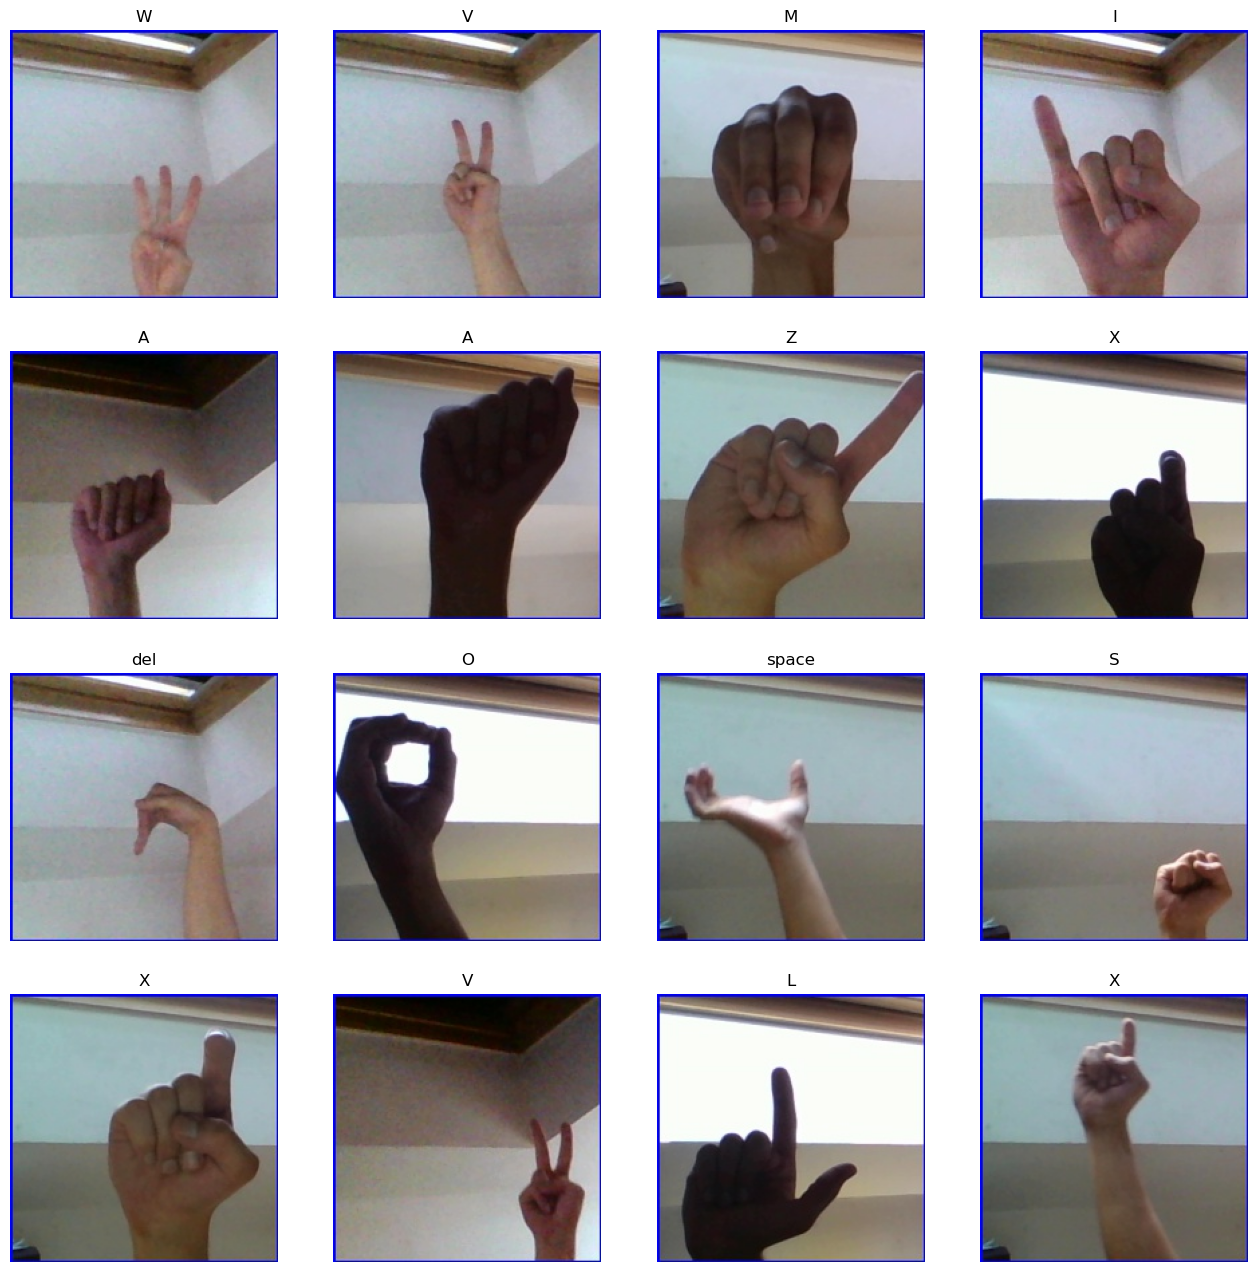

In [107]:
visualize_samples(train_images)

In [108]:
# Neural network architecture

pretrainedModel = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)



17225924/17225924 [==============================] - 2s 0us/step


In [109]:
# Compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [110]:
# Fit model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2,
 )

Epoch 1/2


1088/1088 [==============================] - 3867s 4s/step - loss: 0.2410 - accuracy: 0.9225 - val_loss: 0.1101 - val_accuracy: 0.9624
Epoch 2/2
1088/1088 [==============================] - 2732s 3s/step - loss: 0.0941 - accuracy: 0.9691 - val_loss: 0.0837 - val_accuracy: 0.9737


In [111]:
model.save("SignL.h5","labels.txt")

D:\Jwalitha\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


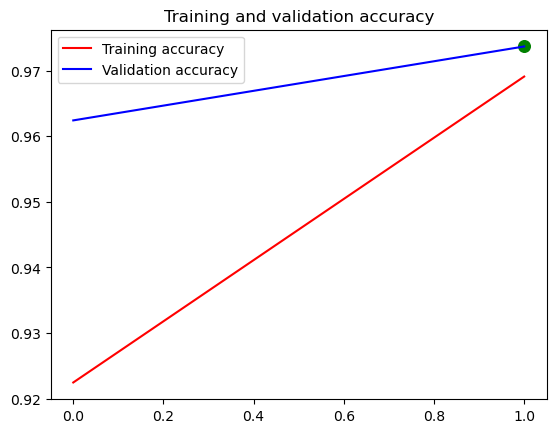

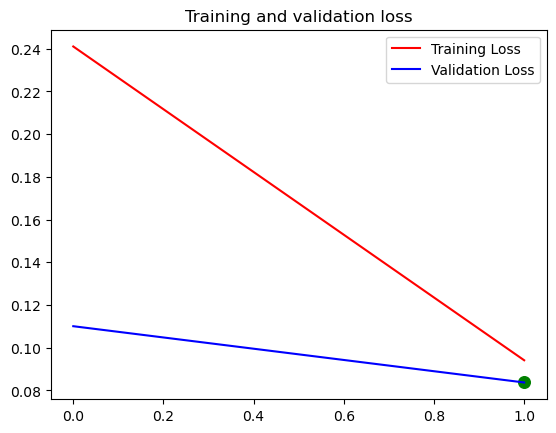

In [112]:
# Training & Validation <> Loss & Accuracy

%matplotlib inline
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs = np.arange(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.scatter(epochs[val_acc.argmax()], val_acc.max(), color='green', s=70)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(epochs[val_loss.argmin()], val_loss.min(), color='green', s=70)
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [2]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('SignL.h5')


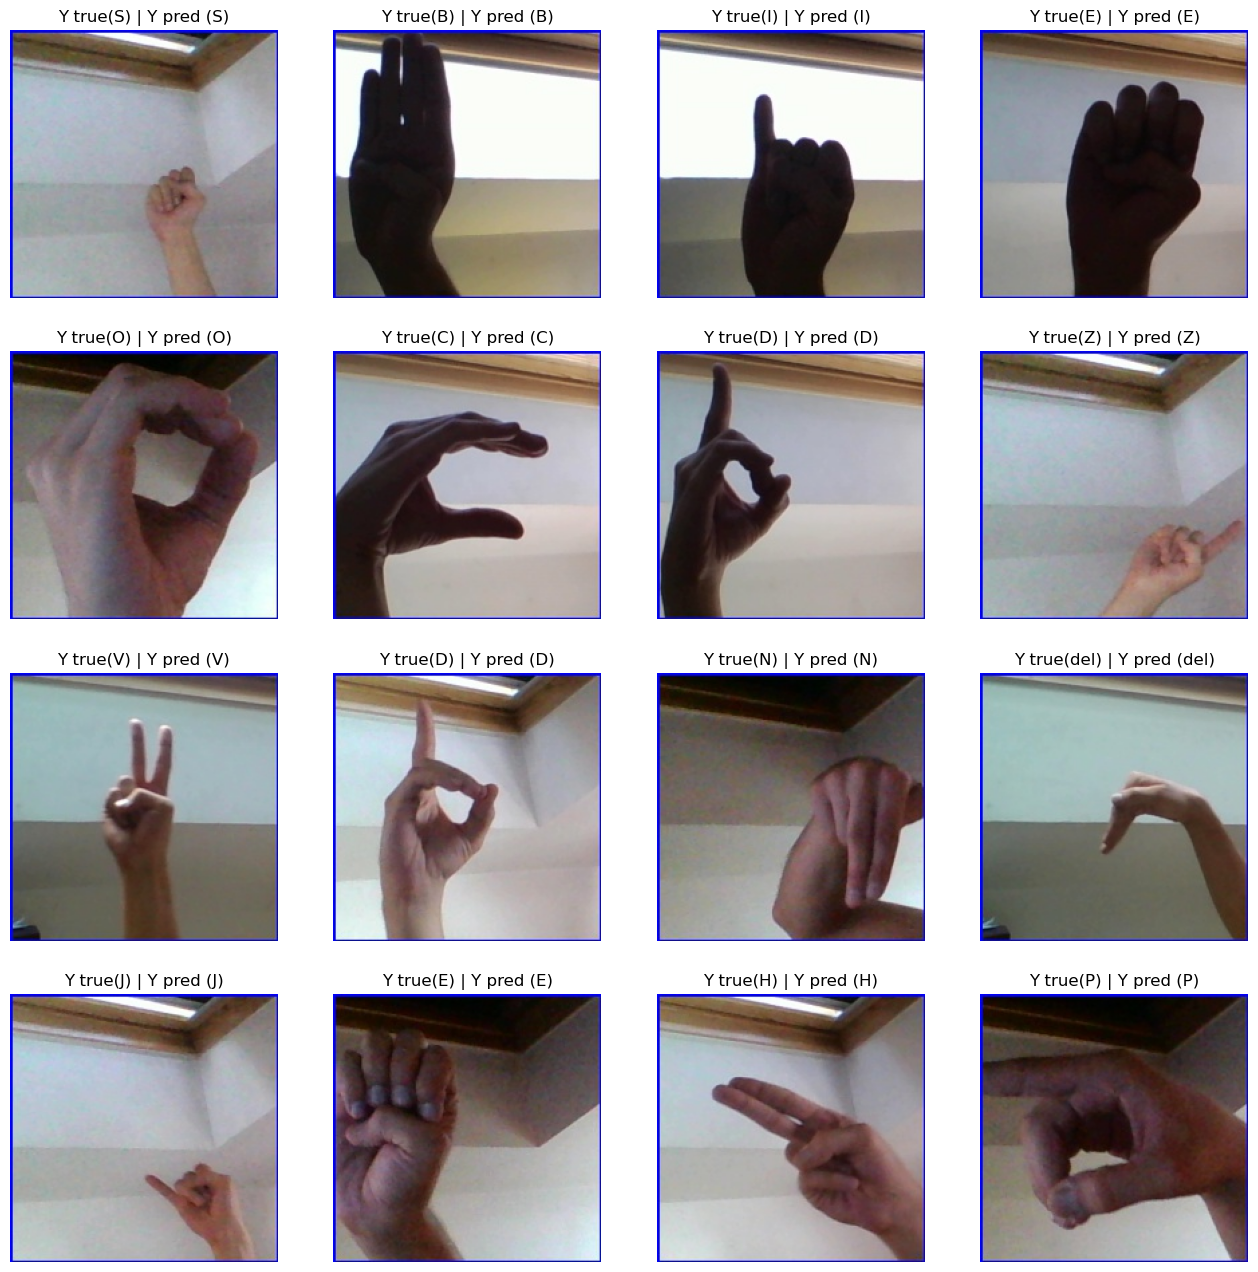

In [118]:
# Visualize classifications on validation set
visualize_classifications(model, val_images)

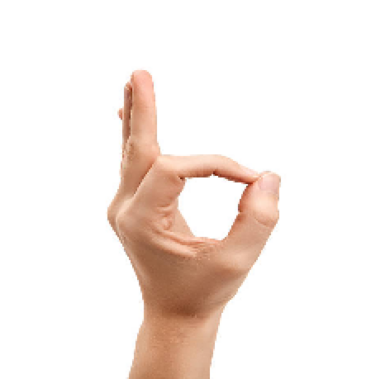

1/1 [==============================] - 3s 3s/step
[[1.52545397e-06 6.51189103e-10 3.85498794e-07 2.47530788e-02
  6.45773753e-07 1.52525783e-04 1.48731483e-09 7.45067636e-12
  2.15737382e-04 1.06193454e-06 1.40633489e-07 1.00774578e-07
  5.68201752e-09 7.96886582e-07 9.74730551e-01 2.81780758e-05
  5.49043699e-10 1.12112766e-05 5.94091125e-06 4.12971879e-08
  4.75645408e-07 1.13779866e-08 1.78562061e-11 9.68429667e-05
  1.39312235e-07 1.48548366e-07 4.72185346e-10 3.97642509e-11
  4.20218583e-07]]


In [9]:
# Assuming you have already trained and saved your model
model = load_model('SignL.h5')
# Replace 'path/to/your/image.jpg' with the actual path to your image
img_path = r'D:/Jwalitha/Projects/AIML/Machine learning projects/SIGN LANGUAGE/Code and Screenshots/o.jpg'
# Load the image and preprocess it
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

print(predictions)


In [11]:
# Assuming 'predictions' is the array of predicted probabilities
predicted_class_index = np.argmax(predictions)

# Manually map the class index to your custom class labels
custom_class_labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z","del","nothing","space"]  # Replace with your actual class labels
predicted_class_label = custom_class_labels[predicted_class_index]

# Print the predicted class label and its corresponding probability
print("Predicted class:", predicted_class_label)
print("Accuracy", predictions[0][predicted_class_index])


Predicted class: O
Accuracy 0.97473055
